In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, pearsonr, spearmanr, mannwhitneyu
import numpy as np
import datetime as dt

In [3]:
payments = pd.read_excel('diploma.xlsx', sheet_name = 'Данные')
clients = pd.read_excel('diploma.xlsx', sheet_name = 'Clients')
region = pd.read_excel('diploma.xlsx', sheet_name = 'Region_dict')

Отчистим данные от нуловых значений


In [4]:
payments = payments[~((payments['id_client'].isnull()) | (payments['amt_payment'].isnull()) | (payments['dtime_pay'].isnull()))]

clients['dtime_ad'] = clients['dtime_ad'].apply(pd.Timestamp)

clients = clients[~clients['dtime_ad'].isnull()]

**Исследуем количество торговых точек в каждом городе** - построим группировку по количеству в каждом городе и визуализируем с помощью гистограммы. 

In [5]:
city = region.groupby('city')['id_trading_point'].count().reset_index()
city.columns = ('city', 'cnt_trading_points')
city.sort_values('cnt_trading_points', ascending = False)

,city,cnt_trading_points
15,Санкт-Петербург,11
7,Москва,11
4,Казань,6
10,Новосибирск,6
6,Красноярск,5
5,Краснодар,4
14,Самара,4
8,Мурманск,2
18,Сочи,2
16,Саратов,2


Мы можем наблюдать, что самое большое количество торговых точек расположено в Москве(11) и в Санкт-Петербурге(11).

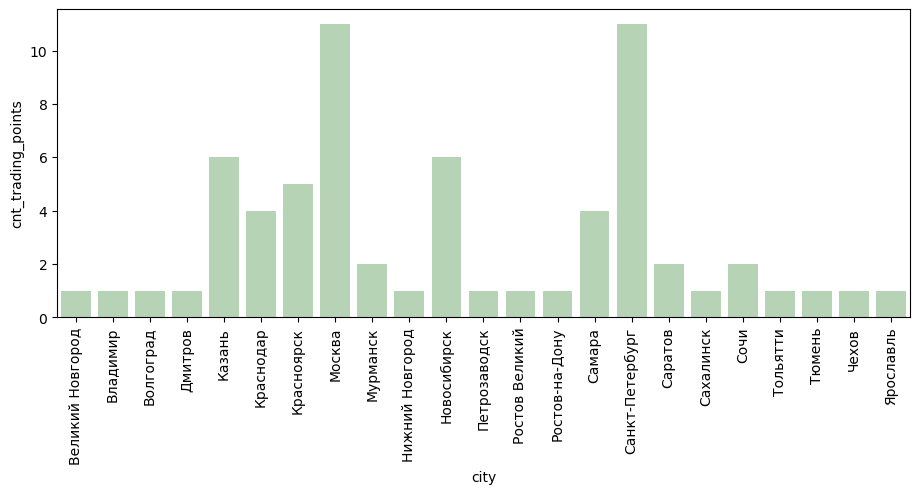

In [9]:
fig = plt.figure(figsize=(11,4))
ax1 = fig.add_subplot()
sns.barplot(x='city', y='cnt_trading_points', data=city, alpha = .3, color = 'green') 
plt.xticks(rotation = 90)
plt.show()

**Построим агрегацию** таблицы с платежами, где вычислим сумму платежей на каждого клиента. Соединим сгруппированную таблицу с клиентской таблицей `clients`. С помощью словаря регионов `region` сразу подтянем к каждой торговой точке город, в котором она находится. Заменим пропуски в `amt_payment` на 0.

In [10]:
all_client_city = payments.merge(clients, on = 'id_client', how = 'outer')
all_client_city = all_client_city.merge(region, on = 'id_trading_point')
all_client_city['amt_payment'] = all_client_city['amt_payment'].fillna(0)


df_cl = all_client_city.groupby(['id_client','id_trading_point','city']).agg({'id_order':'count', 'amt_payment':'sum'}).reset_index()
df_fin = df_cl.merge(clients[['id_client','dtime_ad','nflag_test']], on = 'id_client')

**Создадим** поле флаг платежа `nflag_pay`, который принимает значения 0 или 1 в зависимости от того, заплатил клиент или нет.

In [11]:
df_fin['nflag_pay'] = df_fin['amt_payment'].apply(lambda x: 0 if x == 0 else 1)

**Создадим функцию** `test_calc`, которая будет вычислять значение t-критерия (критерия Стьюдента) и p_value для сравнения средних и с помощью функции print выводить сообщение о том, существует ли разница между средними (на основании p_value).

In [63]:
def test_calc(r1, r2, alpha = 0.05):
    t_stat, p_value = ttest_ind(r1, r2)
    print(f"t-критерий: {t_stat}, p-значение: {p_value}\n")
    if p_value < alpha:
        print("Существует статистически значимая разница между средними значениями.\n")
    else:
        print("Статистически значимой разницы между средними значениями не обнаружено.\n")
        
    print("Среднее значение контрольной группы", r1.mean())
    print("Среднее значение тестовой группы", r2.mean())
    print("Разница средних = ", r1.mean()-r2.mean())
    print(f"P_value = , {p_value}\n")
    return  t_stat, p_value

**Так же создадим функцию** `mann_whitney_func`, которая будет рассчитывать значение критерия Манна Уитни и p_value для сравнения распределений и с помощью функции print выводить сообщение о том, существует ли разница между средними (на основании p_value).

In [13]:
def mann_whitney_func(r1, r2, alpha = 0.05):
    u_stat, p_value = mannwhitneyu(r1, r2)
    print(f"Критерий Манна-Уитни: {u_stat}, p-значение: {p_value}")
    if p_value < alpha:
        print("Существует статистически значимая разница между средними значениями.")
    else:
        print("Статистически значимой разницы между средними значениями не обнаружено.")
    
    print("P_value = ",p_value)
    return u_stat, p_value

**Сделаем пустой список.** Запустим цикл по всем торговым точкам и добавим к этому списку все торговые точки, в которых не было заплачено ни одного рубля ни одним клиентом.

In [20]:
no_payment_points = []

for i in df_fin['id_trading_point'].unique():
    
    df_loc = df_fin[df_fin['id_trading_point']==i]
    sum_a = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==0)].sum(numeric_only=True)['amt_payment'].sum()
    sum_b = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==1)].sum(numeric_only=True)['amt_payment'].sum()
    if (sum_a == 0) | (sum_b == 0):
        no_payment_points.append(i)
        
print(no_payment_points)

[26.0, 739.0, 866.0, 46.0, 1099.0, 1015.0, 603.0, 810.0, 800.0, 228.0, 1.0, 13.0, 23.0, 4.0, 7.0]


Создадим еще один пустой список. Запустим цикл по всем торговым точкам и добавим к этому списку все торговые точки, в которых пустует или контрольная, или тестовая группа.

In [18]:
tp_nflag_zero = []

for i in df_fin['id_trading_point'].unique():
    
    c_a = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==0)].count()['id_client']
    c_b = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==1)].count()['id_client']
    if (c_a == 0) | (c_b == 0):
        tp_nflag_zero.append(i)
        
print(tp_nflag_zero)

[739.0, 866.0, 1099.0, 1015.0, 603.0, 810.0, 800.0, 228.0]


Отбросим все торговые точки, которые мы выявили выше и создадим финальный чистый датафрейм.

In [21]:
data = df_fin[~df_fin['id_trading_point'].isin(tp_nflag_zero + no_payment_points)]
data.head()

,id_client,id_trading_point,city,id_order,amt_payment,dtime_ad,nflag_test,nflag_pay
0,178561.0,453.0,Санкт-Петербург,1,3052.0,2022-06-03 02:47:49.183,0,1
1,178562.0,2652.0,Москва,1,2439.0,2022-06-03 02:51:21.878,0,1
2,178563.0,112.0,Санкт-Петербург,1,768.0,2022-06-03 02:52:10.616,1,1
6,178567.0,453.0,Санкт-Петербург,1,2663.0,2022-06-03 03:02:56.855,0,1
7,178568.0,3786.0,Москва,3,13537.0,2022-06-03 03:05:33.476,1,1


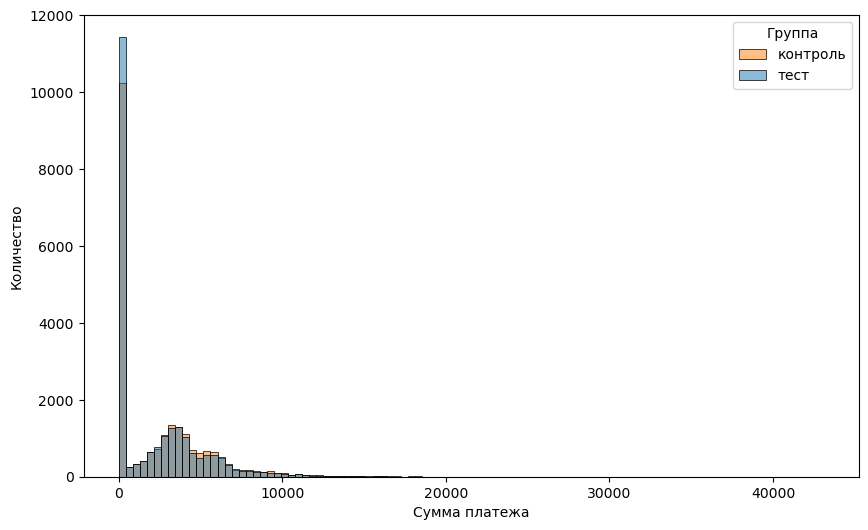

In [25]:
plt.figure(figsize=(10,6))
sns.histplot(data=data, x='amt_payment', hue='nflag_test', bins=100)
plt.xlabel('Сумма платежа')
plt.ylabel('Количество')
plt.legend(title='Группа', labels=['контроль', 'тест'])
plt.show()

На графике мы можем наблюдать, что присутствует огромная группа с нулевыми оплатами. Для оценки среднего чека мы можем убрать их, чтобы не было сильного перекоса в данных. Сознадим новый датафрейм `avg_check`, там будут данные без нулевых оплат.

In [95]:
avg_check = data[data['amt_payment'] != 0]

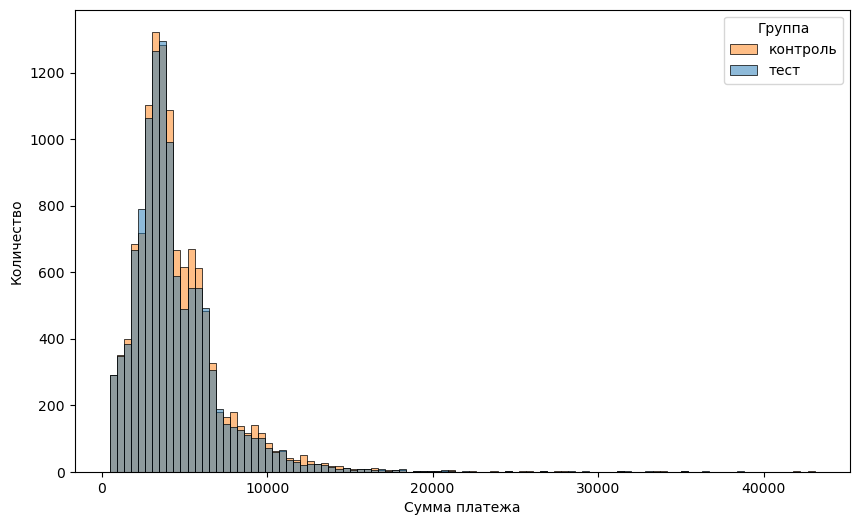

In [24]:
plt.figure(figsize=(10,6))
sns.histplot(data=avg_check, x='amt_payment', hue='nflag_test', bins=100)
plt.xlabel('Сумма платежа')
plt.ylabel('Количество')
plt.legend(title='Группа', labels=['контроль', 'тест'])
plt.show()

Используем функцию `test_calc` на данных. 
Сначала проверим контрольную и тестовую группу на разницу среднего чека. 

In [26]:
control = avg_check[avg_check['nflag_test'] == 0]['amt_payment']
test = avg_check[avg_check['nflag_test'] == 1]['amt_payment']
test_calc(control, test)

t-критерий: -3.7720145239263196, p-значение: 0.0001623297686129223

Существует статистически значимая разница между средними значениями.

Среднее значение контрольной группы 4380.483509754177
Среднее значение тестовой группы 4513.807200262424
Разница средних =  -133.32369050824673
P_value =  0.0001623297686129223


(-3.7720145239263196, 0.0001623297686129223)

Теперь проверим на разницу конверсии.

In [28]:
control = data[data['nflag_test'] == 0]['nflag_pay']
test = data[data['nflag_test'] == 1]['nflag_pay']
test_calc(control, test)

t-критерий: -9.282032730948323, p-значение: 1.7338073027564523e-20

Существует статистически значимая разница между средними значениями.

Среднее значение контрольной группы 0.49975954181786386
Среднее значение тестовой группы 0.5432835820895522
Разница средних =  -0.043524040271688325
P_value =  1.7338073027564523e-20


(-9.282032730948323, 1.7338073027564523e-20)

In [30]:
control = avg_check[avg_check['nflag_test'] == 0]['amt_payment']
test = avg_check[avg_check['nflag_test'] == 1]['amt_payment']

mann_whitney_func(control, test)

Критерий Манна-Уитни: 67519217.0, p-значение: 3.2820854478734935e-05
Существует статистически значимая разница между средними значениями.
P_value =  3.2820854478734935e-05


(67519217.0, 3.2820854478734935e-05)

Сделаем сегментацию на города. Проведем проверку отдельно по Москве, отдельно по Санкт-Петербургу и отдельно по остальным городам вместе.

In [31]:
spb = data[data['city'] == 'Санкт-Петербург']
spb_check = spb[spb['amt_payment'] != 0]

msk = data[data['city'] == 'Москва']
msk_check = msk[msk['amt_payment'] != 0]

oth_cities = data[~data['city'].isin(['Москва', 'Санкт-Петербург'])] 
oth_cities_check = oth_cities[oth_cities['amt_payment'] != 0]

**Санкт-Петербург**

In [32]:
control = spb_check[spb_check['nflag_test'] == 0]['amt_payment']
test = spb_check[spb_check['nflag_test'] == 1]['amt_payment']
test_calc(control, test)

t-критерий: -2.293269025691862, p-значение: 0.021879269472817705

Существует статистически значимая разница между средними значениями.

Среднее значение контрольной группы 4267.9673038229375
Среднее значение тестовой группы 4436.706825657895
Разница средних =  -168.7395218349575
P_value =  0.021879269472817705


(-2.293269025691862, 0.021879269472817705)

In [33]:
control = spb[spb['nflag_test'] == 0]['nflag_pay']
test = spb[spb['nflag_test'] == 1]['nflag_pay']
test_calc(control, test)

t-критерий: -9.352468686561785, p-значение: 1.065825659919673e-20

Существует статистически значимая разница между средними значениями.

Среднее значение контрольной группы 0.44835363103292736
Среднее значение тестовой группы 0.5471316085489314
Разница средних =  -0.09877797751600403
P_value =  1.065825659919673e-20


(-9.352468686561785, 1.065825659919673e-20)

**Москва**

In [34]:
control = msk_check[msk_check['nflag_test'] == 0]['amt_payment']
test = msk_check[msk_check['nflag_test'] == 1]['amt_payment']
test_calc(control, test)

t-критерий: -4.5661294704223945, p-значение: 5.0615538078886085e-06

Существует статистически значимая разница между средними значениями.

Среднее значение контрольной группы 4070.460322686862
Среднее значение тестовой группы 4356.646970605879
Разница средних =  -286.18664791901665
P_value =  5.0615538078886085e-06


(-4.5661294704223945, 5.0615538078886085e-06)

In [35]:
control = msk[msk['nflag_test'] == 0]['nflag_pay']
test = msk[msk['nflag_test'] == 1]['nflag_pay']
test_calc(control, test)

t-критерий: -6.190312288026297, p-значение: 6.194689260032549e-10

Существует статистически значимая разница между средними значениями.

Среднее значение контрольной группы 0.4879498714652956
Среднее значение тестовой группы 0.5435278774046299
Разница средних =  -0.05557800593933432
P_value =  6.194689260032549e-10


(-6.190312288026297, 6.194689260032549e-10)

**Остальные города**

In [36]:
control = oth_cities_check[oth_cities_check['nflag_test'] == 0]['amt_payment']
test = oth_cities_check[oth_cities_check['nflag_test'] == 1]['amt_payment']
test_calc(control, test)

t-критерий: -1.2155888531662078, p-значение: 0.2241639457809073

Статистически значимой разницы между средними значениями не обнаружено.

Среднее значение контрольной группы 4562.379019669061
Среднее значение тестовой группы 4624.491754822651
Разница средних =  -62.11273515359062
P_value =  0.2241639457809073


(-1.2155888531662078, 0.2241639457809073)

In [37]:
control = oth_cities[oth_cities['nflag_test'] == 0]['nflag_pay']
test = oth_cities[oth_cities['nflag_test'] == 1]['nflag_pay']
test_calc(control, test)

t-критерий: -2.6871624139823846, p-значение: 0.007211139569659334

Существует статистически значимая разница между средними значениями.

Среднее значение контрольной группы 0.5244371674171101
Среднее значение тестовой группы 0.5417158267318388
Разница средних =  -0.017278659314728717
P_value =  0.007211139569659334


(-2.6871624139823846, 0.007211139569659334)

**Соберем единую таблицу** по всем торговым точкам. Добавим основную информацию по каждой торговой точке в эту таблицу.

In [72]:
result = pd.DataFrame()

for i in data['city'].unique():
    df_loc = data[data['city']==i]
    
    for j in df_loc['id_trading_point'].unique():
        
        df_loc_f      = df_loc[df_loc['id_trading_point']==j]
        
        count_test    = len(df_loc_f[df_loc_f['nflag_test']==1])
        count_control = len(df_loc_f[df_loc_f['nflag_test']==0])
        count_all     = count_test + count_control
        percent_count = count_all / data["id_order"].count()
        
        sigma_test    = df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'].std()
        sigma_control = df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'].std()
        
        avg_test    = np.mean(df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'])
        avg_control = np.mean(df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'])
        diff        = avg_test - avg_control
        
        s_a,p_a  = test_calc(df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'], df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'])
        s_p,p_p  = test_calc(df_loc_f[df_loc_f['nflag_test']==1]['nflag_pay'], df_loc_f[df_loc_f['nflag_test']==0]['nflag_pay'])
        m_s, m_p = mann_whitney_func(df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'], df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'])

        result = result.append({  'city':i, 'id_trading_point':j
                                        , 'count_test':count_test, 'count_control':count_control, 'count_all':count_all, 'percent_count':percent_count
                                        , 'avg_payment_test':avg_test, 'avg_payment_control':avg_control, 'diff':diff 
                                        , 'sigma_test':sigma_test, 'sigma_control':sigma_control
                                         , 'ttest':s_a, 'pvalue_ttest':p_a}, ignore_index=True)
                                      

t-критерий: 4.976910182958596, p-значение: 6.983206901274464e-07

Существует статистически значимая разница между средними значениями.

Среднее значение контрольной группы 2501.966228893058
Среднее значение тестовой группы 1889.9237368922784
Разница средних =  612.0424920007797
P_value = , 6.983206901274464e-07

t-критерий: 5.541075590734413, p-значение: 3.381305634110329e-08

Существует статистически значимая разница между средними значениями.

Среднее значение контрольной группы 0.5562851782363978
Среднее значение тестовой группы 0.43660629170638704
Разница средних =  0.11967888653001074
P_value = , 3.381305634110329e-08

Критерий Манна-Уитни: 627565.5, p-значение: 1.8091938713109172e-07
Существует статистически значимая разница между средними значениями.
P_value =  1.8091938713109172e-07
t-критерий: 1.7707120159517762, p-значение: 0.07683710303752554

Статистически значимой разницы между средними значениями не обнаружено.

Среднее значение контрольной группы 2488.115030674847
Средне

C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({  'city':i, 'id_trading_point':j
C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({  'city':i, 'id_trading_point':j
C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({  'city':i, 'id_trading_point':j
C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({ 

t-критерий: 2.750751894358415, p-значение: 0.006168215295010464

Существует статистически значимая разница между средними значениями.

Среднее значение контрольной группы 2977.6293103448274
Среднее значение тестовой группы 2277.6117647058823
Разница средних =  700.0175456389452
P_value = , 0.006168215295010464

t-критерий: 2.5248127210101807, p-значение: 0.011893805487505831

Существует статистически значимая разница между средними значениями.

Среднее значение контрольной группы 0.6681034482758621
Среднее значение тестовой группы 0.5568627450980392
Разница средних =  0.11124070317782286
P_value = , 0.011893805487505831

Критерий Манна-Уитни: 34134.5, p-значение: 0.002467608598588329
Существует статистически значимая разница между средними значениями.
P_value =  0.002467608598588329
t-критерий: 2.0999906224732117, p-значение: 0.036305006065519056

Существует статистически значимая разница между средними значениями.

Среднее значение контрольной группы 2925.1422222222222
Среднее значени

C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({  'city':i, 'id_trading_point':j
C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({  'city':i, 'id_trading_point':j
C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({  'city':i, 'id_trading_point':j
C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({ 

t-критерий: -1.1714333415366178, p-значение: 0.24176615429820064

Статистически значимой разницы между средними значениями не обнаружено.

Среднее значение контрольной группы 0.6516587677725119
Среднее значение тестовой группы 0.690176322418136
Разница средних =  -0.03851755464562412
P_value = , 0.24176615429820064

Критерий Манна-Уитни: 81738.5, p-значение: 0.5415888161602205
Статистически значимой разницы между средними значениями не обнаружено.
P_value =  0.5415888161602205
t-критерий: 0.1685059656667099, p-значение: 0.8663043555057068

Статистически значимой разницы между средними значениями не обнаружено.

Среднее значение контрольной группы 1859.777027027027
Среднее значение тестовой группы 1804.25
Разница средних =  55.52702702702709
P_value = , 0.8663043555057068

t-критерий: 1.284455354777848, p-значение: 0.20002209981015495

Статистически значимой разницы между средними значениями не обнаружено.

Среднее значение контрольной группы 0.44594594594594594
Среднее значение тестово

C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({  'city':i, 'id_trading_point':j
C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({  'city':i, 'id_trading_point':j
C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({  'city':i, 'id_trading_point':j
C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({ 

t-критерий: 1.5045563456740754, p-значение: 0.1333273246710206

Статистически значимой разницы между средними значениями не обнаружено.

Среднее значение контрольной группы 2902.4105263157894
Среднее значение тестовой группы 2439.4610778443116
Разница средних =  462.9494484714778
P_value = , 0.1333273246710206

t-критерий: 1.185144360467606, p-значение: 0.2367531179978554

Статистически значимой разницы между средними значениями не обнаружено.

Среднее значение контрольной группы 0.6421052631578947
Среднее значение тестовой группы 0.5808383233532934
Разница средних =  0.061266939804601295
P_value = , 0.2367531179978554

Критерий Манна-Уитни: 17020.5, p-значение: 0.22134177144014489
Статистически значимой разницы между средними значениями не обнаружено.
P_value =  0.22134177144014489
t-критерий: 2.5769554932923184, p-значение: 0.010095112170351712

Существует статистически значимая разница между средними значениями.

Среднее значение контрольной группы 2547.2200392927307
Среднее значени

C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({  'city':i, 'id_trading_point':j
C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({  'city':i, 'id_trading_point':j
C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({  'city':i, 'id_trading_point':j
C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({ 

t-критерий: 1.8202681201948652, p-значение: 0.06901056074583502

Статистически значимой разницы между средними значениями не обнаружено.

Среднее значение контрольной группы 2499.345794392523
Среднее значение тестовой группы 2185.2147239263804
Разница средних =  314.1310704661428
P_value = , 0.06901056074583502

t-критерий: 0.8226505590013279, p-значение: 0.4108986349888111

Статистически значимой разницы между средними значениями не обнаружено.

Среднее значение контрольной группы 0.5532710280373832
Среднее значение тестовой группы 0.5276073619631901
Разница средних =  0.025663666074193014
P_value = , 0.4108986349888111

Критерий Манна-Уитни: 136856.5, p-значение: 0.1782203706588702
Статистически значимой разницы между средними значениями не обнаружено.
P_value =  0.1782203706588702
t-критерий: -0.8915933629198624, p-значение: 0.3728909035918657

Статистически значимой разницы между средними значениями не обнаружено.

Среднее значение контрольной группы 2259.6230366492146
Среднее знач

C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({  'city':i, 'id_trading_point':j
C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({  'city':i, 'id_trading_point':j
C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({  'city':i, 'id_trading_point':j
C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({ 

Критерий Манна-Уитни: 36596.5, p-значение: 1.4503145247971591e-08
Существует статистически значимая разница между средними значениями.
P_value =  1.4503145247971591e-08
t-критерий: 4.806666195414569, p-значение: 2.1646756758588107e-06

Существует статистически значимая разница между средними значениями.

Среднее значение контрольной группы 2762.2242990654204
Среднее значение тестовой группы 1508.8350515463917
Разница средних =  1253.3892475190287
P_value = , 2.1646756758588107e-06

t-критерий: 5.15104085329627, p-значение: 4.0491589219422855e-07

Существует статистически значимая разница между средними значениями.

Среднее значение контрольной группы 0.6495327102803738
Среднее значение тестовой группы 0.4020618556701031
Разница средних =  0.24747085461027074
P_value = , 4.0491589219422855e-07

Критерий Манна-Уитни: 26311.5, p-значение: 8.315735094395254e-07
Существует статистически значимая разница между средними значениями.
P_value =  8.315735094395254e-07
t-критерий: 4.02795072796689

C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({  'city':i, 'id_trading_point':j
C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({  'city':i, 'id_trading_point':j
C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({  'city':i, 'id_trading_point':j
C:\Users\skile\AppData\Local\Temp\ipykernel_19672\99313840.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({ 

**Сделаем новую колонку** `nflag_result`, где будет отображаться один из трех лейблов, в зависимости от результата теста в данной торговой точке.

In [81]:
result['nflag_result'] = result.apply(lambda row: 'pos' if row['diff'] > 0 and row['pvalue_ttest'] < 0.05 else 'neg' if row['diff'] < 0 and row['pvalue_ttest'] < 0.05 else 'neu', axis=1)

Разделим реузльтаты на отдельные датафреймы, в зависимости от исхода тестирования.

In [79]:
positive = result[result['nflag_result'] == 'pos']
negative = result[result['nflag_result'] == 'neg']
neutral = result[result['nflag_result'] == 'neu']

In [94]:
writer = pd.ExcelWriter("result.xlsx", engine="xlsxwriter")

positive.to_excel (writer, sheet_name = 'positive', index = False)
negative.to_excel (writer, sheet_name = 'negative', index = False)
neutral.to_excel (writer, sheet_name = 'neutral', index = False)

writer.close()

**Выводы**: 
- Если не сегрегировать данные, то исследование показывает прирост как по среднему чеку, там и по конверсии, относительно контрольной группы и тестовой.  

- При разделении на города, мы можем наблюдать, что в Москве и Петербурге также наблюдается успех. Однако, по остальным городам можно видеть, что хоть прирост по конверсии есть, но по среднему чеку изменений нет.  

- Разделяя данные по конкретным торговым точкам, можно делать выводы на данных, по каждой точке отдельно.  

- Все точки, где АБ тестирование показало положительный результат лежат на листе `positive`, где отрицательный - `negative`. Так же есть торговые точки, где не было замечено статистической разницы - лист `neutral`. Скорее всего, на этих точках не собралось достаточное количество наблюдений.